In [1]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

import numpy as np
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from src.deep_learning.create_model import create_conv_model
from src.data_representations.process_wavs import *
from src.data_representations.process_images import *
from src.deep_learning.vae import VAE
import torch
from torch.utils.data import DataLoader
import umap
from src.util import make_image
import matplotlib.cm as cm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from src.visualization.plot_softchirps import plot
from notebooks.analysis.plotting_config import ORDER, COLOR
import pandas as pd
from src.util import make_image
import librosa


import matplotlib.cm as cm
import matplotlib.colors as colors


def plot_classes(classes_unique, embedding, figsize=(12, 6)):
    order = ORDER['cl']
    color_dict = COLOR['cl']
    
    fig = plt.figure(figsize=(figsize))
    ax = plt.axes()

    ticks = np.arange(0, len(classes_unique))
    if color_dict is None:
        cmap = cm.rainbow
    else:
        cmap = colors.ListedColormap([color_dict[yi] for yi in y_unique])

    if len(ticks) == 1:
        norm = None    
    else:
        norm = colors.BoundaryNorm(np.arange(min(ticks)- .5, max(ticks) + .6, 1), cmap.N)

    plt.scatter(embedding[:, 0], embedding[:, 1], c=y, norm=norm, cmap=cmap,)
    cbar = plt.colorbar(ticks=ticks)
    _ = cbar.ax.set_yticklabels(classes_unique)
    
    
    
def plot_rectangle(X_AXIS_RANGE, Y_AXIS_RANGE, embedding,  specs, y):
    
    mask_X = ((embedding[:, 0] >= X_AXIS_RANGE[0]) * (embedding[:, 0] <=  X_AXIS_RANGE[1]))
    mask_Y = ((embedding[:, 1] >= Y_AXIS_RANGE[0]) * (embedding[:, 1] <=  Y_AXIS_RANGE[1]))
    mask_XY = mask_X * mask_Y

    plt.figure(figsize=(12, 6))

    y_mask = y[mask_XY]
    specs_mask = specs[mask_XY]

    inds = np.arange(0, len(y_mask))
    np.random.shuffle(inds)
    print(inds.shape)
    inds_plot =  inds[:6]

    count = 1
    for i in range(1, 4):
        plt.subplot(1, 3, count)
        plt.imshow(specs_mask[inds[count]])
        print(y_mask[inds[count]])
        count += 1

def grid_plot(specs, gap=3, vmin=0.0, vmax=1.0, ax=None, save_and_close=False, filename='temp.pdf'):
    plt.figure(figsize=(12, 12))
    if type(gap) == type(4):
        gap = (gap,gap)
    try:
        a, b, c, d = specs.shape
    except:
        print("Invalid shape:", specs.shape, "Should have 4 dimensions.")
        quit()
    dx, dy = d+gap[1], c+gap[0]
    height = a*c + (a-1)*gap[0]
    width = b*d + (b-1)*gap[1]
    img = np.zeros((height, width))
    for j in range(a):
        for i in range(b):
            img[j*dy:j*dy+c,i*dx:i*dx+d] = specs[-j-1,i]
    for i in range(1,b):
        img[:,i*dx-gap[1]:i*dx] = np.nan
    for j in range(1,a):
        img[j*dy-gap[0]:j*dy,:] = np.nan
    if ax is None:
        ax = plt.gca()
    ax.imshow(img, aspect='equal', interpolation='none', )
    ax.axis('off')
    if save_and_close:
        plt.tight_layout()
        #plt.savefig(filename)
        plt.close('all')
        
import re
def name_to_class(sound_name):
    return re.sub('_[0-9]*', '', sound_name).replace(' ', '').replace('2', 'two').replace('.wav', '')

%matplotlib inline


2021-10-10 15:16:14.766835: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [5]:
path_to_data =  PATH_TO_PROJECT + '/toydata_vae/'
sr = 22050
sound_names = [s for s in os.listdir(path_to_data) if '.wav' in s]
sound_classes = np.array([name_to_class(s) for s in sound_names])
classes_unique = list(set([name_to_class(s) for s in sound_names]))
wavs = [librosa.load(path_to_data + sound_name)[0] for sound_name in sound_names]

In [6]:
denoise = False
denoising_params = {'sr': sr,
                    'stationary':False,
                    'n_fft': 256, 
                    'time_constant_s': 2, 
                    'freq_mask_smooth_hz': 500, }

sound_params = {'stretching_lim_train' : None, 'stretching_lim_test' : None,
                'noise_lim_train' : None, 'noise_lim_test' : None, 'filtering_th' : None }

spec_params = {'num_freq_bins': 128,
               'num_time_bins': 128,
               'nperseg': 512, 
               'noverlap': 256, 
               'min_freq': 2000,
               'max_freq': 11025,
               'spec_min_val': -10, 
               'spec_max_val': 0,
               'remove_dc_offset': True, 
               'mel': False, 
               'max_dur': 0.4, 
               'time_stretch': True}

sounds_npy = list(process_waves(wavs, sound_params['stretching_lim_train'], sound_params['noise_lim_train'], 
                                sound_params['filtering_th']))
specs = np.array([np.flip(sound_to_spec_vae(s, spec_params, sr=22050,), 0) for s in sounds_npy])

In [4]:
path_to_model = PATH_TO_PROJECT + 'models/vae/'
model_name = 'toydata-vae_denoise=%s' % denoise
model_folder = path_to_model + model_name

model = VAE(save_dir='.', lr=7e-4, z_dim=32, model_precision=10.0, device_name="auto")
model.load_state(model_folder + '/model')

data = [torch.from_numpy(S, ).cuda().float() for S in specs]
dl = DataLoader(data, batch_size=1, shuffle=True, sampler=None,)

print(model_folder)

RuntimeError: No CUDA GPUs are available

In [7]:
#latent_features = model.get_latent(dl)
#latend_features_scaled = StandardScaler().fit_transform(latent_features)
mfcc_features_raw = [librosa.feature.mfcc(s, n_mfcc=30) for s in sounds_npy]
mfcc_features = np.array([np.concatenate([f.min(1), f.mean(1), f.max(1)]) for f in mfcc_features_raw])

/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1588
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1941
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1676
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1500
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2029
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
/opt/conda/lib/python3.7/site-packages/librosa

### Plots

In [18]:
use_mfcc = True
use_tsne = True
classes_to_use = 'all'
if classes_to_use != 'all':
    mask = np.array([cl in classes_to_use for cl in sound_classes], dtype='bool')
else:
    mask = np.ones(len(sound_classes), dtype='bool')
    
ftrs_to_use = mfcc_features[mask] if use_mfcc else latend_features_scaled[mask]

if use_tsne:
    transform = TSNE(n_components=2, perplexity=30.0)
else:
    transform = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1, metric='euclidean', random_state=42)



In [22]:
from sklearn.decomposition import KernelPCA

In [ ]:
{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’}, 

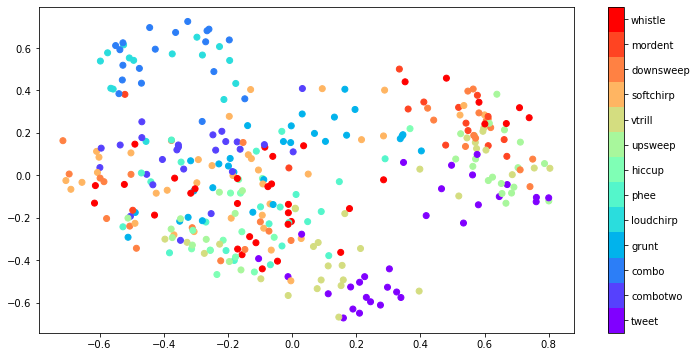

In [36]:
ftrs_to_use_sc = StandardScaler().fit_transform(ftrs_to_use)

transform = KernelPCA(n_components=2, kernel='cosine', degree=3)   
embedding = transform.fit_transform(ftrs_to_use_sc)


plot_classes(classes_unique, embedding,)

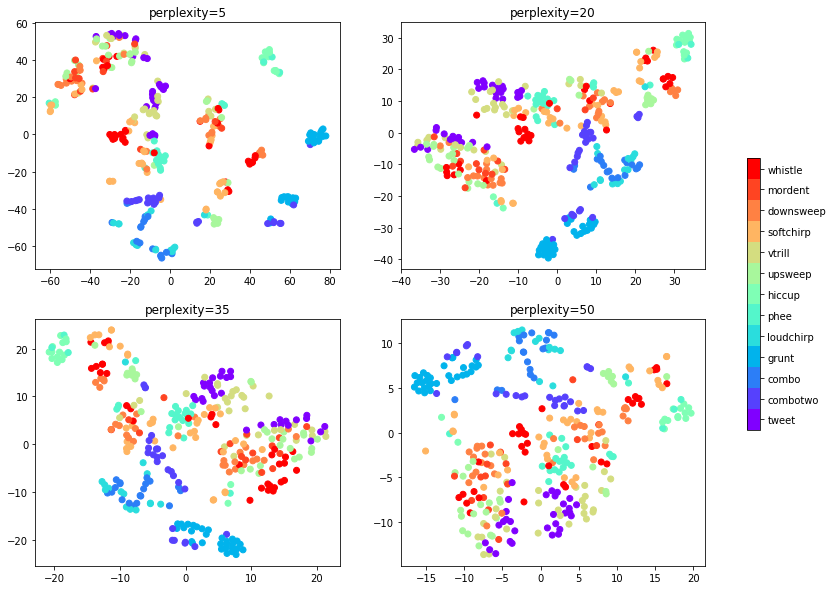

In [17]:
order = ORDER['cl']
color_dict = COLOR['cl']

n_neighbors_to_plot = np.arange(5, 66, 15)
perplexities_to_plot = np.arange(5, 66, 15)

fig, ax = plt.subplots(2, 2, figsize=(15,10))
use_mfcc = True
use_tsne = True

classes_to_use = 'all'
if classes_to_use != 'all':
    mask = np.array([cl in classes_to_use for cl in sound_classes], dtype='bool')
else:
    mask = np.ones(len(sound_classes), dtype='bool')
    
    
y = [classes_unique.index(s) for s  in sound_classes]
ax = np.reshape(ax, -1)
ftrs_to_use = mfcc_features[mask] if use_mfcc else latend_features_scaled[mask]

for ind in range(4):
    
    if use_tsne:
        perplexity = perplexities_to_plot[ind]
        transform = TSNE(n_components=2, perplexity=perplexity)
    else:
        n_neighbors = n_neighbors_to_plot[ind]
        transform = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=0.1, metric='euclidean', random_state=42)
    embedding = transform.fit_transform(ftrs_to_use)
        
    ticks = np.arange(0, len(classes_unique))
    if color_dict is None:
        cmap = cm.rainbow
    else:
        cmap = colors.ListedColormap([color_dict[yi] for yi in y_unique])
    if len(ticks) == 1:
        norm = None    
    else:
        norm = colors.BoundaryNorm(np.arange(min(ticks)- .5, max(ticks) + .6, 1), cmap.N)

    p = ax[ind].scatter(embedding[:, 0], embedding[:, 1], c=y, norm=norm, cmap=cmap,)
    #_ = cbar.ax.set_yticklabels(classes_unique)
    if use_tsne:
        ax[ind].set_title('perplexity=%d' % perplexity)
    else:
        ax[ind].set_title('n_neighbors=%d' % n_neighbors)

cb = fig.colorbar(p, ax=ax, ticks=ticks, location='right', shrink=.5)
cb.set_ticklabels(classes_unique)

### Classification

In [ ]:
def grid_plot(specs, gap=3, vmin=0.0, vmax=1.0, ax=None, save_and_close=False, filename='temp.pdf'):
    plt.figure(figsize=(12, 12))
    if type(gap) == type(4):
        gap = (gap,gap)
    try:
        a, b, c, d = specs.shape
    except:
        print("Invalid shape:", specs.shape, "Should have 4 dimensions.")
        quit()
    dx, dy = d+gap[1], c+gap[0]
    height = a*c + (a-1)*gap[0]
    width = b*d + (b-1)*gap[1]
    img = np.zeros((height, width))
    for j in range(a):
        for i in range(b):
            img[j*dy:j*dy+c,i*dx:i*dx+d] = specs[-j-1,i]
    for i in range(1,b):
        img[:,i*dx-gap[1]:i*dx] = np.nan
    for j in range(1,a):
        img[j*dy-gap[0]:j*dy,:] = np.nan
    if ax is None:
        ax = plt.gca()
    ax.imshow(img, aspect='equal', interpolation='none', )
    ax.axis('off')
    if save_and_close:
        plt.tight_layout()
        #plt.savefig(filename)
        plt.close('all')

In [45]:
%matplotlib inline
indices = np.random.choice(np.arange(len(dl.dataset)), size=5 ,replace=False)
specs_original = torch.stack([dl.dataset[ind] for ind in indices]).to(model.device)


with torch.no_grad():
    _, _, reconstructed_specs = model.forward(specs_original, return_latent_rec=True)
    specs_original = specs_original.detach().cpu().numpy()
    all_specs = np.stack([specs_original, reconstructed_specs])
    grid_plot(all_specs, gap=10, filename='save_filename')
 

### Examples

In [5]:
x_range = (-3, 3)
y_range = (-10, 0)
plot_rectangle(x_range, y_range, embedding,  specs,  sound_classes)